In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import beta 
import scipy.stats as st
import pandas as pd
import time
import scipy

In [2]:
df_bayesian=pd.read_pickle('bayesian_results.pkl')

In [3]:
df_frequentist=pd.read_pickle('frequentist_results.pkl')

Text(0, 0.5, 'count')

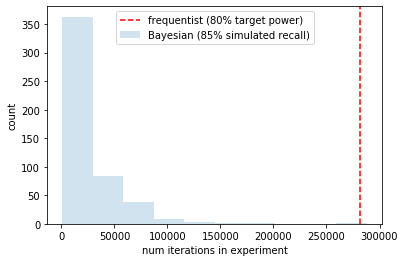

In [16]:
plt.figure()
plt.hist(df_bayesian['sample size'],alpha=.2,label='Bayesian (85% simulated recall)')
plt.axvline(df_frequentist['sample size'].iloc[0],color='red',linestyle='--',label='frequentist (80% target power)')
plt.legend()
plt.xlabel('num iterations in experiment')
plt.ylabel('count')

In [51]:
def num_samples_per_threshold(threshold,base_loss,treatment_loss):
    """
    calculate the number of iterations and experiment winner for a given experiment given a minimum loss threshold
    
    @inputs: threhold--> minimnum expected loss needed to end experiment
             base_loss--> loss function for control group as a funciton of sample iteration
             treatment_loss--> loss function for treatment group as a funciton of sample iteration
    
    @outputs: experiment result, num samples
              experiment result: 1 - treatment is preferred, 0 - base preferred
              num sample--> number of samples needed to determine winner
    """
    num_iterations=0
    loop_num=0
    
    while base_loss[loop_num]>threshold and treatment_loss[loop_num]>threshold:
        num_iterations+=1000
        loop_num+=1

    if treatment_loss[loop_num]<threshold:
        
        return 1,num_iterations
    
    else:
        
        return 0, num_iterations

In [18]:
thresholds=np.logspace(-5,-3,20)*4
bayesian_experiment_results=[0]*len(thresholds)

for i, threshold in enumerate(thresholds):
    bayesian_experiment_results[i]=df_bayesian[['base losses','treatment losses']].apply(lambda x:num_samples_per_threshold(threshold,*x),axis=1)

In [52]:
def gen_bootstrapped_pow_num_samples(df_x,num_straps=10000,sigma=1.96):
    
    """
    function calculates bootstrapped averages and standard errors for the binary success proprotions/experiment lengths
    from a sample of experiment outcomes
    
    @inputs: df_x--> inputs Series object where each row is a tuple of form (experiment winner, sample size)
             num_straps--> number of bootstrap samples to collect
             sigma---> how many sigma to return for standard error 
    
    @outputs: mean of binary proportion, 2 sigma standard error of mean, mean experiment length, 2 sigma standard error of length
    """
        
    power_bootstraps=[]
    sample_size_bootstraps=[]
    for i in range(num_straps):
        boot_strap_instances=np.array(df_x.iloc[np.random.randint(len(df_x), size=len(df_x))])
        power_avg=np.mean([i[0] for i in boot_strap_instances])
        sample_size_avg=np.mean([i[1] for i in boot_strap_instances])
        power_bootstraps.append(power_avg)
        sample_size_bootstraps.append(sample_size_avg)
    return np.mean(power_bootstraps),np.std(power_bootstraps)*sigma,np.mean(sample_size_bootstraps),np.std(sample_size_bootstraps)*sigma

In [8]:
threshold_avg_results=[0]*len(thresholds)
for i in range(len(thresholds)):
    threshold_avg_results[i]=gen_bootstrapped_pow_num_samples(bayesian_experiment_results[i])

In [9]:
filtered_avg_results=[i for i in threshold_avg_results if i[2]>4000]

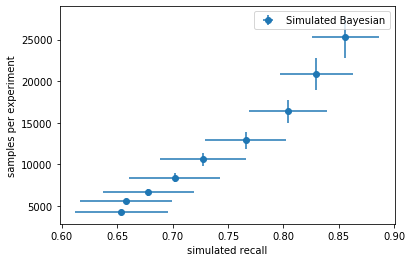

In [19]:
#plot the sample length as a function of experimental recall 
plt.figure()
x_vals= [i[0] for i in filtered_avg_results]
x_errs=[i[1] for i in filtered_avg_results]
y_vals= [i[2] for i in filtered_avg_results]
y_errs=[i[3] for i in filtered_avg_results]
plt.errorbar(x_vals, y_vals,xerr=x_errs, yerr=y_errs, fmt='o',label='Simulated Bayesian')
plt.xlabel('simulated recall')
plt.ylabel('samples per experiment')
plt.legend()
plt.show()

In [11]:
power_avgs=np.array([np.mean([i[0] for i in np.array(bayesian_experiment_results[j])]) for j in range(len(bayesian_experiment_results))])
sample_size_dist=[[i[1] for i in np.array(bayesian_experiment_results[j])] for j in range(len(bayesian_experiment_results))]

In [12]:
#extract the sample size needed to  conduct a frequentist AB test of a given power 
#base rate and min effect size are hardcoded to match with other notebooks

def freq_sample_size(power):

    Z_alpha=np.abs(st.norm.ppf(.025/2))
    Z_beta=np.abs(st.norm.ppf(1-power))

    base_rate=.002
    min_effect_size=.0004

    sample_size=(Z_alpha+Z_beta)**2*((2*base_rate+min_effect_size)*(1-(2*base_rate+min_effect_size)/2))\
                                     /(min_effect_size)**2
    
    return sample_size

freq_powers=np.linspace(.6,.95,20)
freq_ss=[freq_sample_size(power) for power in freq_powers]

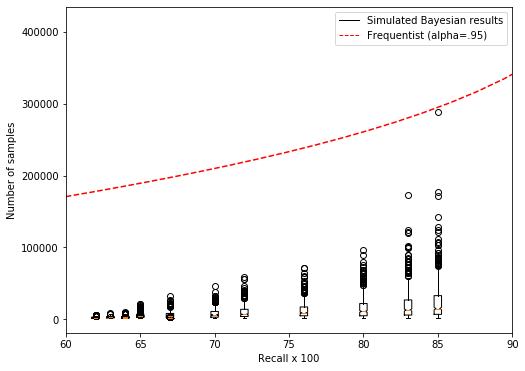

In [21]:
#plot distribution of sample sizes for Bayesian test and compare to the theoreical value needed for frequentist AB tests


%matplotlib inline


import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

f,ax=plt.subplots(1,1,figsize=(8,6))
# Plot a line between the means of each dataset
ax.plot(100*freq_powers, freq_ss, linestyle='--',color='red',label='frequentist (alpha=.95)')

# Save the default tick positions, so we can reset them...
locs, labels = plt.xticks() 

bp=ax.boxplot(sample_size_dist[:-5][::-1],positions=np.array([int(100*i) for i in power_avgs[:-5][::-1]]), notch=True)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Reset the xtick locations.
#plt.xticks(locs)
ax.set_xlim(60,90)
ax.set_xlabel('Recall x 100')
ax.set_ylabel('Number of samples')
ax.legend([bp["boxes"][0],Line2D([0], [0], color='red', lw=1,ls='--')], ['Simulated Bayesian results','Frequentist (alpha=.95)'], loc='upper right')
plt.show()

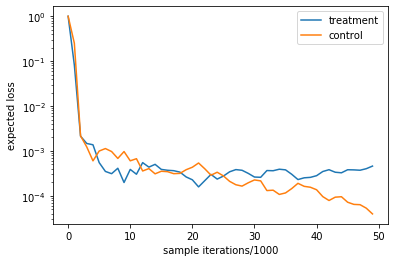

In [50]:
#Looks the expected loss and a function of sample iteration for a sample experiment simulation

plt.plot(df_bayesian['treatment losses'].iloc[10],label='treatment')
plt.plot(df_bayesian['base losses'].iloc[10],label='control')
plt.xlabel('sample iterations/1000')
plt.ylabel('expected loss')
plt.yscale('log')
plt.legend()